In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy

Calculate gravity of polygon

" Computing the gravitaional and magnetic anomalies due to a polygon: Algorithems and Fortran subroutines' Won 1986


In [468]:
def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)

def B(x,z,p1,p2):
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))

def theta(x,z, p):
    if x[p] != 0 :
        if(np.arctan(z[p]/x[p]))<0:
            return(np.arctan(z[p]/x[p])+scipy.pi)
        else:
            return(np.arctan(z[p]/x[p]))
    if x[p] == 0 and z[p]!=0 :
        return(scipy.pi/2)

def r(x,z,p):
    return(np.sqrt(x[p]**2+z[p]**2))

def Z(x,z,p1,p2):
    
    if x[p1] == z[p1]==0 or x[p2] == z[p2]==0:
        return(0)
    
    if x[p1] == x[p2]:
        return((x[p1]*np.log(r(x,z,p2)/r(x,z,p1))))
    
    theta1 = theta(x,z, p1)
    theta2 = theta(x,z, p2)
    
    r1 = r(x,z,p1)
    r2 = r(x,z,p2)
    
    #this is only needed when observation location across z
#     if z[p1]*z[p2]<0:
#         if x[p1]*z[p2]==x[p2]*z[p1]:
#             return(0)
#         if x[p1]*z[p2] < x[p2]*z[p1] and z[p2]>=0:
#             theta1 += 2*scipy.pi
#         if x[p1]*z[p2] > x[p2]*z[p1] and z[p1]>=0:
#             theta2 += 2*scipy.pi
    
    _A = A(x,z,p1,p2)
    _B = B(x,z,p1,p2)
    
    Z_result = _A*((theta1-theta2)+_B*np.log(r1/r2))
    return(Z_result)

Gravity at origin is calculated as $\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}$
(Won, 1987)

In [615]:
def g(data,loc=(0,0)):
    
    G = 6.67 * 10**(-11) # gravitational constant  m^3 kg ^-1 s^-2
    rho = 1000        # density difference   kg/m^3
    
    _data = data - loc #Calculate any point refer to the origin

    _x = _data[:,0]
    _z = _data[:,1]

    Z_sum = 0
    
    for i in range(_data.shape[0]-1):
        Z_sum += Z(_x,_z,i,i+1)

    Z_sum += Z(_x,_z,-1,0)

    g = 2*G*rho * Z_sum
    
    return(g)

In [555]:
def draw(points,ax = None,R = 100):
    if ax == None:
        f,ax=plt.subplots()
    x = points[:,0]
    z = points[:,1]
    for i in range(points.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'r-')
    x_ = np.linspace(-R,R,10)
    ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
    ax.plot([x[0],x[-1]],[z[0],z[-1]],'r-')
    ax.set_ylim(min(points[:,1])-10,5)
    ax.set_xlim(-R,R)
    
def grav_calculate(points, R=70,ax = None):
    if ax == None:
        f,ax=plt.subplots()
    x = np.linspace(-R,R,501)
    y = np.zeros(np.shape(x))
    obv = np.vstack((x,y)).T
    gravity = []
    for i in obv:
        gravity.append(-g(points,i))
    ax.plot(x,gravity)
    return gravity
    
def plot_results(points,R =max(points[:,0]) ):
    f , axs = plt.subplots(2 , sharex = True, figsize = (7,10))
    grav_calculate(points, R=max(points[:,0]),ax = axs[0])
    draw(points,ax = axs[1],R=R)
    

In [556]:
x = np.linspace(-50,50,501)
y = np.zeros(np.shape(x))
obv = np.vstack((x,y)).T

In [557]:
points=np.array([[-1,-11],
              [1, -11],
              [1, -10],
              [-1, -10]])

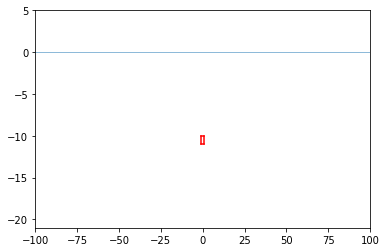

In [558]:
draw(points)

<b> "note: if z is positive downward and x is positive to the right, then the polygen vertices must be specified clock-wise. " --Won 1987

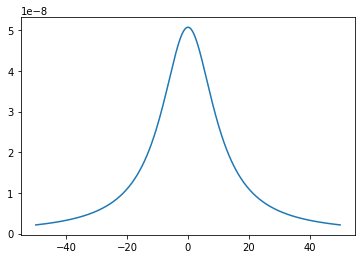

In [559]:
gravity = []
for i in obv:
    gravity.append(-g(points,i))
plt.plot(x,gravity)


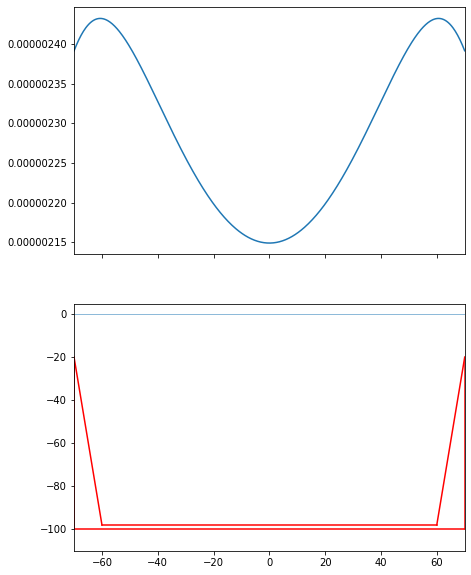

In [560]:
points=np.array([[-70,-100],
              [70, -100],
              [70, -20],
              [60, -98],
              [-60,-98],
              [-70,-20]])
plot_results(points,70)

In [618]:
#define a pseudo boundary condition and corner points
corners=np.array([[-200,-5],# bottom left coner
              [200,-5], 
              [200,-0.5], # bottom right coner
              [70, -0.5], # top right coner
              [-70,-0.5],# top left coner
              [-200,-0.5]])

In [619]:
corners.shape

(6, 2)

set up the problem

In [620]:
N = 10
points = np.empty((N+6,2))

for i in range(corners.shape[0]-2):
    points[i] = corners[i]
    
points[-2]=corners[-2]
points[-1]=corners[-1]

# np.random.seed(2)

x = np.linspace(-70,70,N+2)

y = np.random.uniform(min(corners[:,1]),max(corners[:,1]),N)

In [621]:
for i in range(N):
    points[i+4][1] = y[i]
for i in range(N):
    points[i+4][0] = x[-i-2]

In [622]:
points

array([[-200.        ,   -5.        ],
       [ 200.        ,   -5.        ],
       [ 200.        ,   -0.5       ],
       [  70.        ,   -0.5       ],
       [  57.27272727,   -4.60596871],
       [  44.54545455,   -4.86234733],
       [  31.81818182,   -3.3928928 ],
       [  19.09090909,   -2.34598104],
       [   6.36363636,   -4.76499773],
       [  -6.36363636,   -4.7045135 ],
       [ -19.09090909,   -4.80424466],
       [ -31.81818182,   -3.22182159],
       [ -44.54545455,   -1.99207829],
       [ -57.27272727,   -4.108878  ],
       [ -70.        ,   -0.5       ],
       [-200.        ,   -0.5       ]])

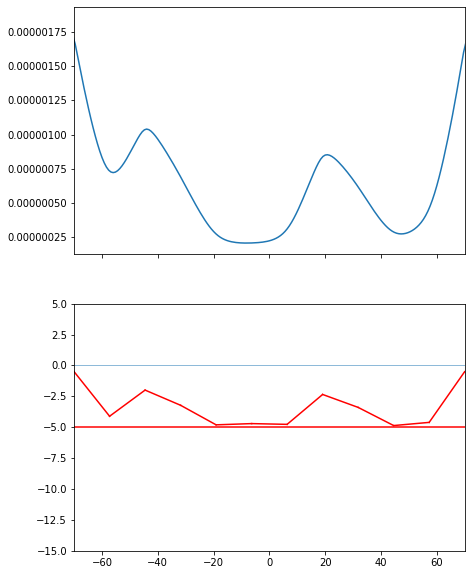

In [623]:
plot_results(points,70)

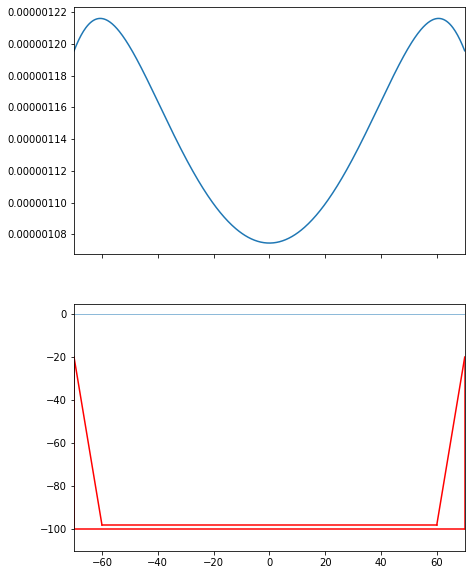

In [624]:
points=np.array([[-70,-100],
              [70, -100],
              [70, -20],
              [60, -98],
              [-60,-98],
              [-70,-20]])
plot_results(points,70)

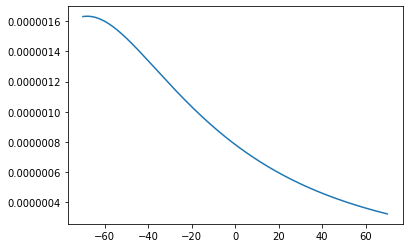

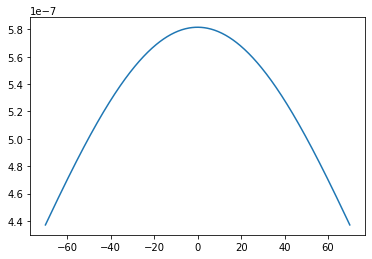

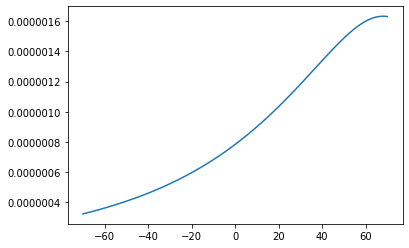

In [531]:
points1=np.array([[-70,-100],
              [-60, -100],
              [-60,-98],
              [-70,-20]])
grav1 = grav_calculate(points1,R=70)

points2 = np.array([[-60,-100],
              [60, -100],
              [60,-98],
              [-60,-98]])
grav2 = grav_calculate(points2,R=70)

points3 = np.array([[60,-100],
              [70, -100],
              [70,-20],
              [60,-98]])
grav3 = grav_calculate(points3,R=70)

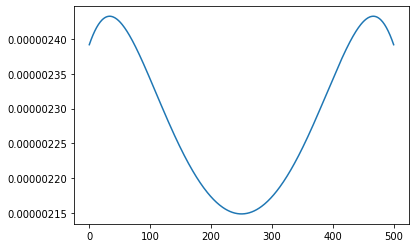

In [575]:
S = np.array((grav1,grav2,grav3))
grav = S.sum(axis=0)
plt.plot(grav)

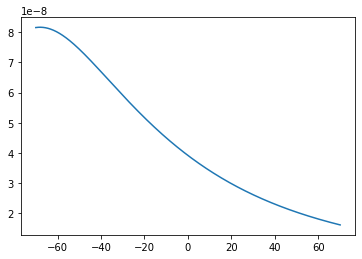

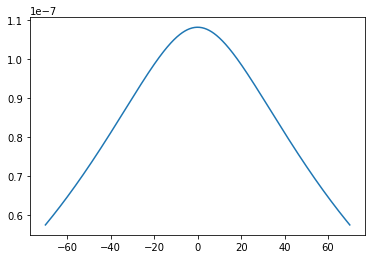

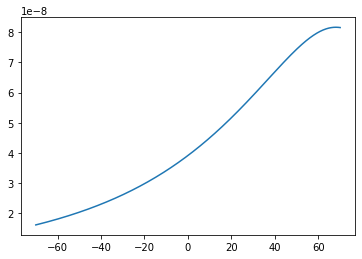

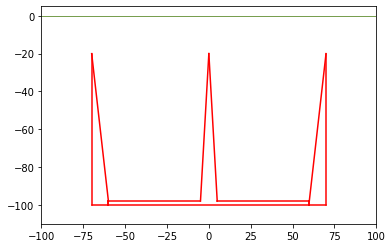

In [606]:
points1=np.array([[-70,-100],
              [-60, -100],
              [-60,-98],
              [-70,-20]])
grav1 = grav_calculate(points1,R=70)

points2 = np.array([[-60,-100],
              [60, -100],
              [60,-98],
              [5,-98],
              [0,-20],
              [-5,-98],
              [-60,-98]])
grav2 = grav_calculate(points2,R=70)

points3 = np.array([[60,-100],
              [70, -100],
              [70,-20],
              [60,-98]])
grav3 = grav_calculate(points3,R=70)

f,axe = plt.subplots()
draw(points1,axe)
draw(points2,axe)
draw(points3,axe)


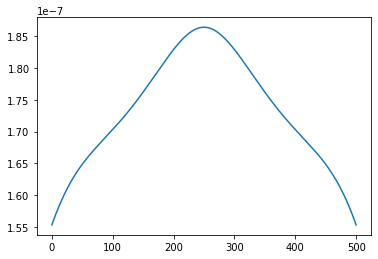

In [607]:
S = np.array((grav1,grav2,grav3))
grav = S.sum(axis=0)
plt.plot(grav)

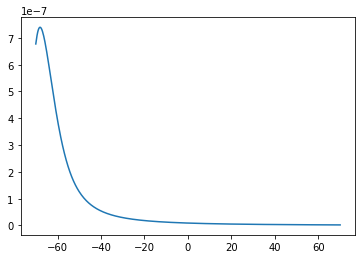

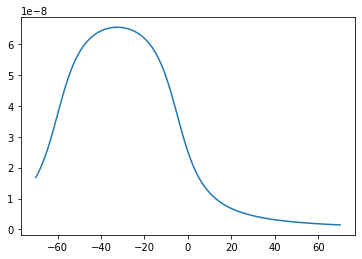

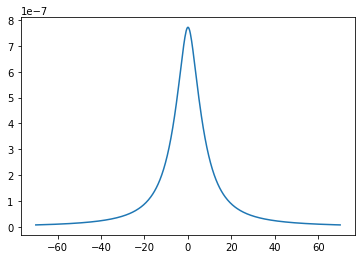

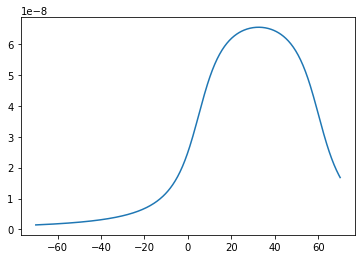

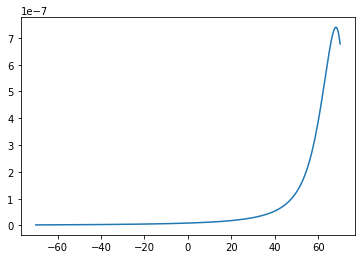

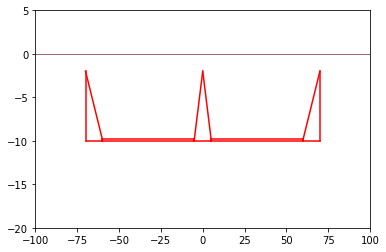

In [616]:
points1=np.array([[-70,-10],
              [-60, -10],
              [-60,-9.8],
              [-70,-2]])
grav1 = grav_calculate(points1,R=70)

points2 = np.array([[-60,-10],
                [-5,-10],
              [-5,-9.8],
              [-60,-9.8]])
grav2 = grav_calculate(points2,R=70)

points3 = np.array([[-5,-10],
                [5,-10],
              [5,-9.8],
              [0,-2],
              [-5,-9.8]])
grav3 = grav_calculate(points3,R=70)


points4 = np.array([[5,-10],
                [60,-10],
              [60,-9.8],
              [5,-9.8]])
grav4 = grav_calculate(points4,R=70)


points5 = np.array([[60,-10],
              [70, -10],
              [70,-2],
              [60,-9.8]])
grav5 = grav_calculate(points5,R=70)

f,axe = plt.subplots()
draw(points1,axe)
draw(points2,axe)
draw(points3,axe)
draw(points4,axe)
draw(points5,axe)



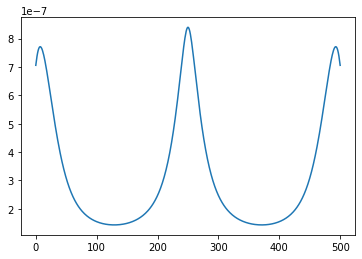

In [617]:
S = np.array((grav1,grav2,grav3,grav4,grav5))
grav = S.sum(axis=0)
plt.plot(grav)

When put to the near surface, the fluctuation 